# THR-Exploration

Import data and conduct experiments to answer questions about ALL/AML correlation

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import re
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from utils import *

In [3]:
%%time
corr_df = load_tsv('/data/archive/compendium/v5/v5_all_by_all.2018-02-04.tsv')
meta_df = load_tsv('/data/archive/compendium/v5/clinical.tsv')
prep_df = load_tsv('~/work/TURG/resources/TreehouseCompendiumSamples_LibraryPrep.tsv')
type_df = pd.read_csv('~/work/TURG/resources/DiseaseAnnotations_2018-04_Labels.csv', sep=',', index_col=1)

CPU times: user 1min 43s, sys: 24.5 s, total: 2min 7s
Wall time: 2min 7s


### How correlated are other ALL samples with AML?

Specifically, what impact does RiboD preparation have on their correlation? Use the `type_df` to find ALL samples of interest.

This section is the only one where preparation type matters, as in every other case I search only in the correlation matrix which contains only PolyA-prepared samples.

In [90]:
samples_with_ALL = get_samples_by_disease(ALL, type_df, meta_df)

Number of donors missing from file structure: 150


In [116]:
%%time
fracs_aml = pd.Series()
sources = pd.Series()
prep_types = pd.Series()
corr_fracs = {
    'TCGA': pd.Series(),
    'THR': pd.Series(),
    'TARGET': pd.Series(),
    'TH': pd.Series()}
aml_fracs = {
    'TCGA': pd.Series(),
    'THR': pd.Series(),
    'TARGET': pd.Series(),
    'TH': pd.Series()}

for sample_id in samples_with_ALL:
    
    # sources
    source = sample_to_source(sample_id)
    sources[sample_id] = source
    
    # prep_types
    sample_prep = prep_df.loc[sample_id]['libSelType']
    if type(sample_prep) == pd.Series:
        sample_prep = sample_prep.iloc[0]
    prep_types[sample_id] = sample_prep
    
    # get correlated diseases
    sample_ids = get_samples_correlated_above_threshold(sample_id, corr_df)
    if sample_ids is None:
        continue
    donor_ids = [sample_to_donor(sample_id) for sample_id in sample_ids]
    disease_counts = type_df.loc[donor_ids]['Diagnosis/Disease'].value_counts()
    disease_distrib = disease_counts / sum(disease_counts)
    
    fracs_aml[sample_id] = disease_distrib[AML] if AML in disease_distrib else 0.0

    # corr_fracs & aml_fracs
    corr_sources = Counter([re.match(r'[a-zA-Z]+', s).group() for s in sample_ids])
    for src in src_fracs.keys():
        corr_fracs[src][sample_id] = corr_sources[src] / sum(corr_sources.values()) if src in corr_sources else 0.0
    
    aml_samples = [s for s in sample_ids if meta_df.loc[s]['disease'] == AML]
    aml_sources = Counter([re.match(r'[a-zA-Z]+', s).group() for s in aml_samples])
    for src in src_fracs.keys():
        aml_fracs[src][sample_id] = aml_sources[src] / sum(aml_sources.values()) if src in aml_sources else 0.0

CPU times: user 23.1 s, sys: 392 ms, total: 23.5 s
Wall time: 23.6 s


In [117]:
corr_fracs = {'frac_'+src: col for src, col in corr_fracs.items()}
aml_fracs = {'aml_frac_'+src: col for src, col in aml_fracs.items()}

samples_df = pd.DataFrame({'frac_AML': fracs_aml, 'source': sources, 'prep_type': prep_types,
                           **corr_fracs, **aml_fracs})
samples_df.index.name = 'THid'
samples_df = samples_df[pd.notnull(samples_df['frac_AML'])]

In [118]:
THR_df = samples_df[samples_df['source'] == 'THR']

In [119]:
palette = sb.color_palette(n_colors=10)
color_1 = palette[0]

In [120]:
THR_df.head()

,aml_frac_TARGET,aml_frac_TCGA,aml_frac_TH,aml_frac_THR,frac_AML,frac_TARGET,frac_TCGA,frac_TH,frac_THR,prep_type,source
THid,,,,,,,,,,,
THR08_0161_S01,0.020619,0.886598,0.0,0.092784,0.515957,0.159574,0.457447,0.015957,0.367021,polyASelection,THR
THR08_0161_S02,0.021978,0.879121,0.0,0.098901,0.594771,0.071895,0.522876,0.006536,0.398693,polyASelection,THR
THR08_0162_S01,0.129032,0.580645,0.0,0.290323,0.254098,0.245902,0.147541,0.040984,0.565574,polyASelection,THR
THR08_0162_S02,0.021277,0.872340,0.0,0.106383,0.531073,0.118644,0.463277,0.011299,0.406780,polyASelection,THR
THR08_0163_S01,0.000000,0.897727,0.0,0.102273,0.536585,0.091463,0.481707,0.012195,0.414634,polyASelection,THR


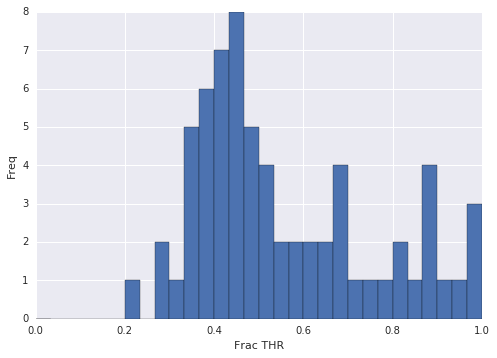

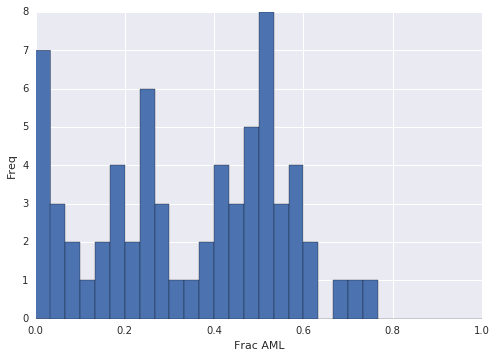

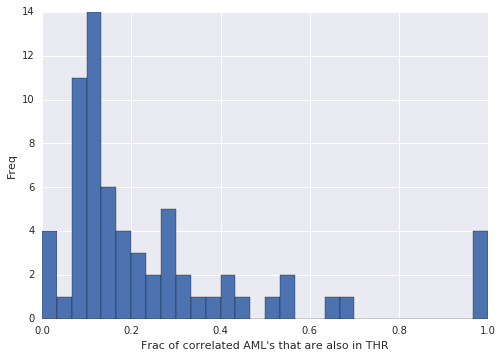

In [126]:
plt.hist(THR_df['frac_THR'], bins=30, range=(0, 1), color=color_1, alpha=1.0)
plt.xlabel('Frac THR')
plt.ylabel('Freq')
plt.show()

plt.hist(THR_df['frac_AML'], bins=30, range=(0, 1), color=color_1, alpha=1.0)
plt.xlabel('Frac AML')
plt.ylabel('Freq')
plt.show()

plt.hist(THR_df['aml_frac_THR'], bins=30, range=(0, 1), color=color_1, alpha=1.0)
plt.xlabel('Frac of correlated AML\'s that are also in THR')
plt.ylabel('Freq')
plt.show()

In [48]:
sub_sources = pd.Series()
for sample in samples_with_ALL:
    m = re.search(r'[0-9][0-9]', sample)
    sub_src = sample[m.start():m.end()]
    sub_sources[sample] = sub_src
samples_df['sub_source'] = sub_sources

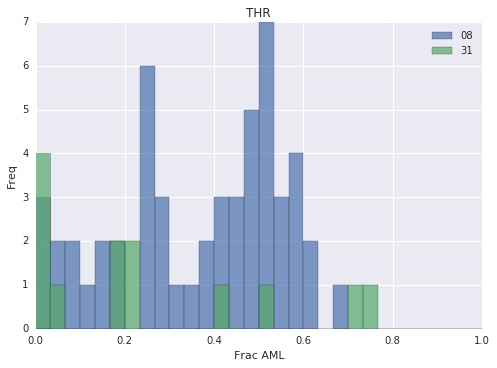

In [68]:
src_constraint = samples_df['source'] == 'THR'
sub_srcs = samples_df.loc[src_constraint]['sub_source'].unique()
constraints = {sub_src: (src_constraint & (samples_df['sub_source'] == sub_src)) for sub_src in sub_srcs}

for i, (subsrc, constraint) in enumerate(constraints.items()):
    plot_criterion(samples_df, constraint, title='THR', color=palette[i], alpha=0.7, label=subsrc)
    plt.legend(loc='upper right')
plt.show()